Uses an interface into IPOPT to solve sub-problems in iterative convex optimization. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-whitegrid')

from Utils import ipopt  
from EntryGuidance import Mesh 
import EntryGuidance.Convex_PS as Convex
# reload(Convex)
OCP = Convex.OCP

In [5]:
solver = ipopt.Solver()

mesh = Mesh.Mesh(t0=0, tf=10, orders=[4]*10)    
N = len(mesh.times)

x0 = [3,0]
A0 = np.array([[0,1],[-1,0]])
B0 = np.array([0,1])

guess = np.array([np.linspace(x0[0], 0, N), np.zeros((N,))]).T
guess_u = np.zeros(N,)

X0 = solver.create_vars(guess)
U0 = solver.create_vars(guess_u)

Ai = [A0]*N
Bi = [B0]*N

X = mesh.chunk(X0)
U = mesh.chunk(U0)
A = mesh.chunk(Ai)
B = mesh.chunk(Bi)

# End point constraints
solver.Equation(X0[0,0]==x0[0])
solver.Equation(X0[0,1]==x0[1])

solver.Equation(X0[-1,0]==0)
solver.Equation(X0[-1,1]==0)

L = []
for a, x, b, u, d, w in zip(A,X,B,U,mesh.diffs, mesh.weights): # Iterate over mesh segments 
    solver.StateSpace(a, x, b, u, d) # linear dynamic constraints 
    
    # Running cost computation 
    lagrange = u**2
    la_var = solver.model.Var(0.)
    solver.Equation(la_var == w.dot(lagrange)) # The use of these intermediate variables allows the obj to be written as a small sum. This avoids the 15k character limit. 
    L.append(la_var)
    
    # Path constraints:
    [solver.Equation(-2.6-1.3*x1+x2 <= 0) for (x1,x2) in x]
    [solver.Equation(x2 >= -2.) for (x1,x2) in x]

    [solver.Equation(ui**2 <= 1) for ui in u] # control limited to 3 

solver.Obj(sum(L))
# solver.model.options.SOLVER = 0 # for optimizer comparison
solver.solve(True)

x_sol = solver.get_values(X0)
u_sol = solver.get_values(U0)

print(dir(solver.model.options))

 ----------------------------------------------------------------
 APMonitor, Version 0.8.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  283
   Intermediates:  0
   Connections  :  0
   Equations    :  265
   Residuals    :  265
 
 Number of state variables:    283
 Number of total equations: -  264
 Number of slack variables: -  150
 ---------------------------------------
 Degrees of freedom       :    -131
 
 * Warning: DOF <= 0
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the

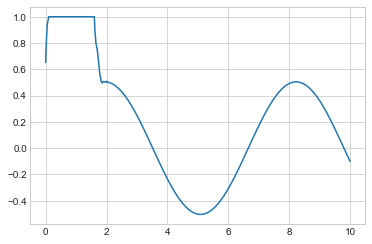

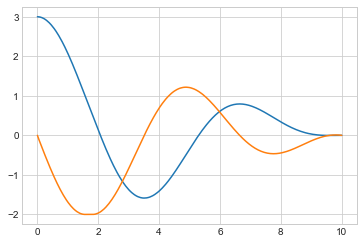

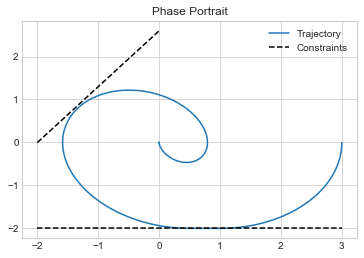

In [4]:
plt.figure()
plt.plot(mesh.times, u_sol)

plt.figure()
plt.plot(mesh.times, x_sol)

plt.figure()
plt.title('Phase Portrait')
plt.plot(x_sol.T[0],x_sol.T[1], label='Trajectory')

x1 = np.linspace(-2,0)
x2 = 1.3*x1 + 2.6
plt.plot(x1,x2,'k--', label='Constraints')

x1 = np.linspace(-2,3)
plt.plot(x1, -2.*np.ones_like(x1),'k--')
plt.legend()

Scalar problem with known optimal solution

In [17]:
solver = ipopt.Solver()

mesh = Mesh.Mesh(t0=0, tf=1, orders=[4]*5)    
N = len(mesh.times)

x0 = [1]
A0 = np.array([0.5])
B0 = np.array([1])

guess = np.linspace(x0[0], 0, N)
guess_u = np.zeros(N,)

X0 = solver.create_vars(guess)
U0 = solver.create_vars(guess_u)

Ai = [A0]*N
Bi = [B0]*N

X = mesh.chunk(X0)
U = mesh.chunk(U0)
A = mesh.chunk(Ai)
B = mesh.chunk(Bi)

# End point constraints
solver.Equation(X0[0]==x0[0])
# solver.Equation(X0[-1]==0)

L = []
for a, x, b, u, d, w in zip(A,X,B,U,mesh.diffs, mesh.weights): # Iterate over mesh segments 
    solver.StateSpace(a, x, b, u, d) # linear dynamic constraints 
    
    # Running cost computation 
    lagrange = u**2 + 2*x**2
    la_var = solver.model.Var(0.)
    solver.Equation(la_var == w.dot(lagrange)) # The use of these intermediate variables allows the obj to be written as a small sum. This avoids the 15k character limit. 
    L.append(la_var)
    
solver.Obj(sum(L))
# solver.model.options.SOLVER = 0 # for optimizer comparison
solver.solve(True)

x_sol = solver.get_values(X0)
u_sol = solver.get_values(U0)

print(dir(solver.model.options))

 ----------------------------------------------------------------
 APMonitor, Version 0.8.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  47
   Intermediates:  0
   Connections  :  0
   Equations    :  32
   Residuals    :  32
 
 Number of state variables:    47
 Number of total equations: -  31
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    16
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).

Here we confirm the results with the analytically known solution:

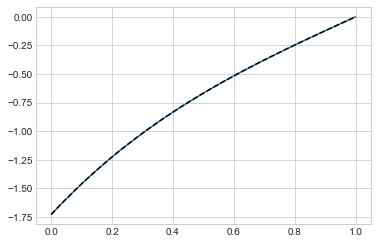

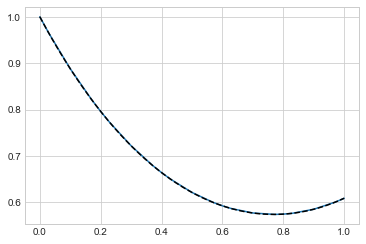

In [18]:
t = np.linspace(0,1)
x_opt = (2*np.exp(3*t)+np.exp(3))/(np.exp(1.5*t)*(2+np.exp(3)))
u_opt = (2*np.exp(3*t)-2*np.exp(3))/(np.exp(1.5*t)*(2+np.exp(3)))

plt.figure()
plt.plot(mesh.times, u_sol)
plt.plot(t, u_opt, 'k--')
plt.plot()

plt.figure()
plt.plot(mesh.times, x_sol)
plt.plot(t,x_opt,'k--')




Next step:

Rewrite (or extend) the OCP to use interior-point solver in place of the specific SOCP structured solver

Iteration 0
optimal value:       4.268
Pre-processing time: 0.009 s
Solver time:         0.491 s
Total time:          0.500 s
Mesh refinement resulted in 10 segments with 41 collocation points

Iteration 1
optimal value:       3.883
Pre-processing time: 0.014 s
Solver time:         0.970 s
Total time:          0.984 s
Mesh refinement resulted in 15 segments with 61 collocation points

Iteration 2
optimal value:       3.851
Pre-processing time: 0.017 s
Solver time:         0.965 s
Total time:          0.982 s
Relative change in cost function = 0.84%

Mesh refinement resulted in 15 segments with 71 collocation points

Iteration 3
optimal value:       3.831
Pre-processing time: 0.025 s
Solver time:         2.360 s
Total time:          2.385 s
Relative change in cost function = 0.52%

Mesh refinement resulted in 17 segments with 101 collocation points

Iteration 4
optimal value:       3.822
Pre-processing time: 0.065 s
Solver time:         2.792 s
Total time:          2.856 s
Relative chan

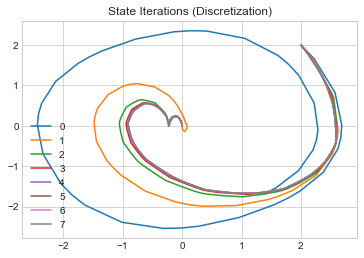

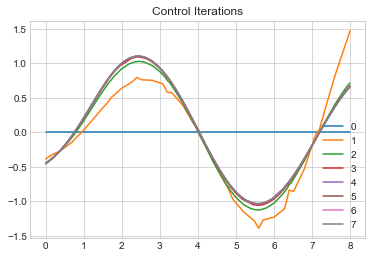

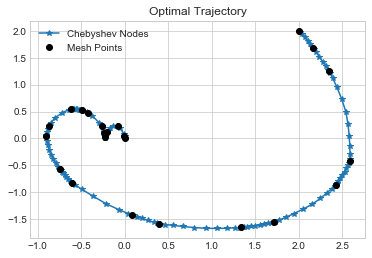

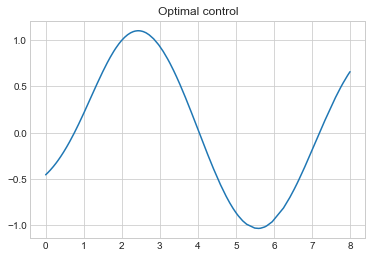

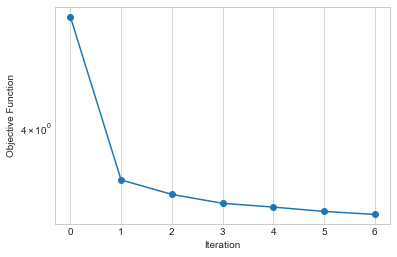

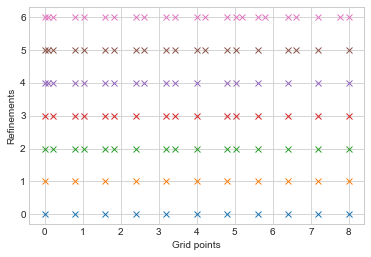

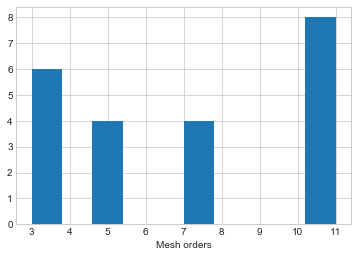

In [8]:
from scipy.interpolate import interp1d

class TestClass(OCP):
    """ A very basic vanderpol oscillator for testing OCP solver """

    def __init__(self, mu, x0, xf, tf):
        self.mu = mu
        self.x0 = x0
        self.xf = xf
        self.tf = tf

    def dyn(self, x):
        # returns f,g evaluated at x (vectorized)
        return np.array([x[1],-x[0] + self.mu*(1-x[0]**2)*x[1]]), np.vstack((np.zeros_like(x[0]),np.ones_like(x[0]))).squeeze()

    def dynamics(self, x, t, u):  # integrable function
        f, g = self.dyn(x)
        return f + g*u

    def jac(self, x, *args):
        x1, x2 = x
        shape = [x.shape[0]]
        shape.extend(x.shape)
        A = np.zeros(shape)

        B = np.vstack((np.zeros_like(x1),np.ones_like(x1))).squeeze()

        A[0,1,:] = np.ones_like(x[0])
        A[1,0,:] = -np.ones_like(x[0]) - 2*self.mu*x1*x2
        A[1,1,:] = self.mu*(1-x[0]**2)

        return np.moveaxis(A, -1, 0), np.moveaxis(B, -1, 0)

    def lagrange(self, t, x, u, xr, ur, *args):
        return (np.array(u)+ur)**2
#         return np.array([ self.solver.model.sqrt(ui**2) for ui in (u+ur) ])

    def mayer(self, *args, **kwargs):
        return 0

    def constraints(self, t, x, u, x_ref, u_ref):
        """ Implements all constraints, including:
            boundary conditions
            control constraints
            trust regions
        """
        for xi, x0i in zip(x[0], x_ref[0]):
            self.solver.Equation(xi==0)
            
        for xi, xfi in zip(x[-1], x_ref[-1]):
            self.solver.Equation(xfi+xi==0)

        trust_region = 4
        umax = 3

        for ti, (xi, xr) in enumerate(zip(x, x_ref)):
#             self.solver.Equation( sum((xi - xr)**2) < trust_region**2 )
            self.solver.Equation((u[ti]+u_ref[ti])**2 <= umax**2)
        return 

    def plot(self, T, U, X, J, ti, tcvx):
        for i, xux in enumerate(zip(T, U, X)):

            t, u, xc = xux

            # plt.figure(1)
            # plt.plot(x[0], x[1], label=str(i))
            # plt.title('State Iterations (Integration)')

            plt.figure(5)
            plt.plot(xc[0], xc[1], label=str(i))
            plt.title('State Iterations (Discretization)')
            plt.figure(2)
            plt.plot(t, u, label=str(i))
            plt.title('Control Iterations')

        plt.figure(3)
        xcvx = interp1d(T[-1], X[-1].T, kind='linear', axis=0, assume_sorted=True)(ti).T
        plt.plot(X[-1][0], X[-1][1], '*-', label='Chebyshev Nodes')
        plt.plot(xcvx[0], xcvx[1], 'ko', label='Mesh Points')
        # plt.plot(X[-1][0], X[-1][1], label='Integration')
        plt.title('Optimal Trajectory')
        plt.legend()

        plt.figure(4)
        plt.plot(T[-1], U[-1])
        plt.title('Optimal control')

        plt.figure(7)
        plt.semilogy(J, 'o-')
        plt.ylabel('Objective Function')
        plt.xlabel('Iteration')

        self.mesh.plot(show=False)
        for fig in [2,3,5]:
            plt.figure(fig)
            plt.legend()
        plt.show()

vdp = TestClass(mu=0.1, x0=[2, 2], xf=[0, 0], tf=8)

guess = {}

t = np.linspace(0,8,20)
u = np.zeros_like(t)
x = vdp.integrate(vdp.x0, 0, t)
# x = np.array([np.linspace(2,0,20)]*2).T

guess['state'] = x
guess['control'] = u 
guess['time'] = t 
guess['mesh'] = [4]*10

sol = vdp.solve(guess, max_iter=7, linesearch=False, plot=True, solver='ipopt', refine=True, verbose=False)
